In [1]:
# import libraries
import os
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import numpy as np
import glob
import datetime
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import math
from tqdm import tqdm
from scipy import interpolate
import matplotlib.dates as mdates
from spacepy import pycdf
from scipy.optimize import curve_fit


In [2]:
# auxiliary functions

# add datetime index
def addDatetimes(df,dftype):
    datetimes = [] 
    
    if dftype == 'mlh':
        for i in iter(range(0,len(df))):
            datetimes.append(datetime.datetime(df['YEAR'][i],
                                               df['MONTH'][i],
                                               df['DAY'][i],
                                               df['HOUR'][i],
                                               df['MIN'][i],
                                               df['SEC'][i]) )
    if dftype == 'grf':
        for i in iter(range(0,len(df))):
            datetimes.append(datetime.datetime(df['yy'][i],
                                               df['mo'][i],
                                               df['dd'][i],
                                               df['hh'][i],
                                               df['mm'][i],
                                               df['ss'][i]) )


        
    df['datetimes'] = datetimes
    df.index = df.datetimes
    
    return df

# define the true objective function
def objective(x, a, b):
    return  a*np.exp(b*x)

# find nearest value in a array 
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# estimate earth radius 
def earth_radius (B):
    B=math.radians(B) #converting into radians
    a = 6378.137  #Radius at sea level at equator
    b = 6356.752  #Radius at poles
    c = (a**2*math.cos(B))**2
    d = (b**2*math.sin(B))**2
    e = (a*math.cos(B))**2
    f = (b*math.sin(B))**2
    R = math.sqrt((c+d)/(e+f))
    return R

# estimate local time zone
def calc_solartime(longitude_local, datetime_UTC):

    longitudes = []
    for i in iter(range(0,13)):
        longitudes.append(7.5 + (15*i))    
    
    longitudes.append(np.abs(longitude_local))
    longitudes.sort()
    
    idx_localtime = np.argwhere(longitudes == np.abs(longitude_local))[0][0]
    if longitude_local >=0:
        datetime_local = datetime_UTC + datetime.timedelta(hours = int(idx_localtime))
    else:
        datetime_local = datetime_UTC - datetime.timedelta(hours = int(idx_localtime))
    
    return datetime_local

In [3]:
# parameters

spatial_window = 5 # km
temporal_window = 15 # min

GRf_freq = 5 # sec

MLH_lat = 42.61 # degrees
MLH_lon = -71.49 # degrees
MLH_timeUTC = -5 # hours


In [4]:
grf_all = pd.read_csv('all_grf_jan.csv') # file file contains altitude estimated by latitude and localtime

# convert dates to datetime
grf_all.datetimes = pd.to_datetime(grf_all.datetimes)
grf_all.datetimes_local = pd.to_datetime(grf_all.datetimes_local)

In [5]:
# get arcs 
grf_arcs = grf_all[grf_all.diff(axis = 0).datetimes > datetime.timedelta(seconds=GRf_freq)]


In [6]:
len(grf_arcs)

284

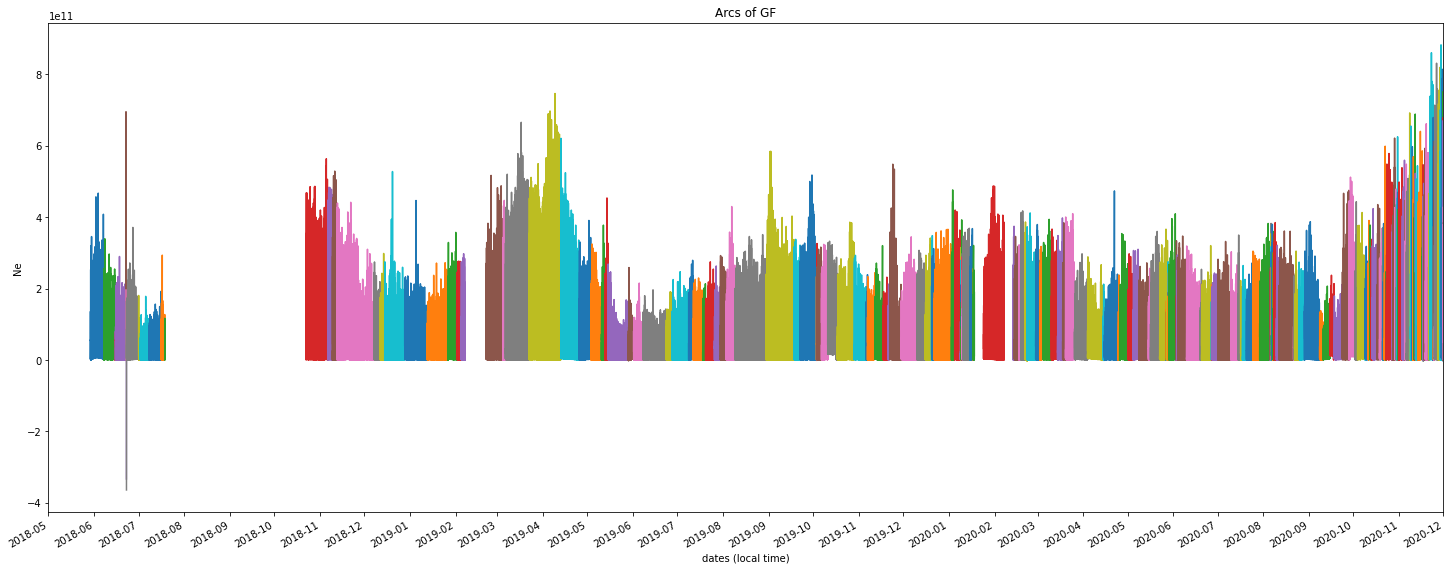

In [7]:
fig, ax = plt.subplots(figsize=(25,10))

# plot all arcs together
date_start = []
minnel = []
for i in iter(range(0,len(grf_arcs))):
    if i == 0:
        plt.plot(grf_all[0:grf_arcs.index[i]]['datetimes'], grf_all[0:grf_arcs.index[i]]['ne'])
        date_start.append(np.min(grf_all[0:grf_arcs.index[i]]['datetimes']))
        minnel.append(np.min(grf_all[0:grf_arcs.index[i]]['ne']))
        pass
    if i == len(grf_arcs)-1:
        plt.plot(grf_all[grf_arcs.index[i]:]['datetimes'], grf_all[grf_arcs.index[i]:]['ne'])
        date_start.append(np.min(grf_all[grf_arcs.index[i]:]['datetimes']))
        minnel.append(np.min(grf_all[grf_arcs.index[i]:]['ne']))

        pass
    else:
        plt.plot(grf_all[grf_arcs.index[i-1]:grf_arcs.index[i]]['datetimes'], grf_all[grf_arcs.index[i-1]:grf_arcs.index[i]]['ne'])
        date_start.append(np.min(grf_all[grf_arcs.index[i-1]:grf_arcs.index[i]]['datetimes']))
        minnel.append(np.min(grf_all[grf_arcs.index[i-1]:grf_arcs.index[i]]['ne']))
        pass
        
ax.xaxis_date()

months =mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlim(pd.Timestamp("2018-05"),pd.Timestamp("2020-12"))

fig.autofmt_xdate()


plt.title('Arcs of GF')
plt.xlabel('dates (local time)')
plt.ylabel('Ne')     

df_min = pd.DataFrame(
    {'min_ne': minnel,
     'date_start':date_start
    })

df_min.to_csv('gap_min.csv')


In [8]:
df_min['nem_ne_e11'] = df_min['min_ne']*10**-11
df_min = df_min[df_min['nem_ne_e11']<0]

df_min.to_csv('gap_min.csv')


In [9]:
df_min

,min_ne,date_start,nem_ne_e11
4,-3.336362e+11,2018-06-15 09:46:37,-3.336362
7,-3.643384e+11,2018-06-22 20:17:27,-3.643384
12,-1.170248e+07,2018-07-18 18:12:42,-0.000117
16,-8.389587e+08,2018-11-12 12:41:17,-0.008390
32,-1.323975e+08,2019-05-10 14:40:52,-0.001324
35,-2.837918e+09,2019-05-28 20:07:22,-0.028379
44,-1.788365e+08,2019-07-26 04:16:22,-0.001788
51,-1.376152e+09,2019-10-03 07:11:32,-0.013762
54,-2.596799e+08,2019-10-03 16:39:22,-0.002597
55,-6.854440e+08,2019-10-03 20:37:27,-0.006854


In [10]:

# plot all arcs together
date_start = []
minnel = []
for i in iter(range(0,len(grf_arcs))):
    if i == 0:
        date_start.append(np.min(grf_all[0:grf_arcs.index[i]]['datetimes']))
        minnel.append(np.min(grf_all[0:grf_arcs.index[i]]['ne']))
        pass
    if i == len(grf_arcs)-1:
        date_start.append(np.min(grf_all[grf_arcs.index[i]:]['datetimes']))
        minnel.append(np.min(grf_all[grf_arcs.index[i]:]['ne']))

        pass
    else:
        date_start.append(np.min(grf_all[grf_arcs.index[i-1]:grf_arcs.index[i]]['datetimes']))
        minnel.append(np.min(grf_all[grf_arcs.index[i-1]:grf_arcs.index[i]]['ne']))
        pass
            

df_min = pd.DataFrame(
    {'min_ne': minnel,
     'date_start':date_start
    })

# df_min.to_csv('gap_min.csv')
df_min[0:10]

,min_ne,date_start
0,0.000000e+00,2018-05-29 11:04:57
1,NaN,NaT
2,0.000000e+00,2018-06-07 14:38:12
3,0.000000e+00,2018-06-15 08:38:12
4,-3.336362e+11,2018-06-15 09:46:37
5,0.000000e+00,2018-06-22 19:25:42
6,0.000000e+00,2018-06-22 20:15:22
7,-3.643384e+11,2018-06-22 20:17:27
8,0.000000e+00,2018-07-01 01:40:12
9,0.000000e+00,2018-07-02 06:49:17


Conjunctions

In [11]:
grf_all[grf_all['datetimes'] == '2018-06-15 09:46:37']

,Unnamed: 0,datetimes,datetimes_local,ne,nel,alt,lat,lon,qd_lat,qd_lon
292498,292498,2018-06-15 09:46:37,2018-06-15 09:46:37,5.144781e+10,10.711367,487.879554,31.359521,5.047696,23.730049,23.730049


In [12]:
# find conjunctions

# list files in alphabetical order
mlh_list = glob.glob('../../../data/Madrigal/MLH/*')
mlh_list.sort()

# grf_list = glob.glob('../../../data/GRACEFO/KBRNE_relative/*/*')
grf_list = glob.glob('../data/interim/GRACEFO/KBRNE_relative_Jan/magftp.gfz-potsdam.de/SWARM/DISC/TIRO/KBR/pre/Python/*/*.cdf')
grf_list.sort()

# create list containing datetimes from file names

mlh_list_datetimes = []

for dates in mlh_list:
    mlh_list_datetimes.append(datetime.datetime(int(dates[30:32]) + 2000,
                  int(dates[32:34]),
                  int(dates[34:36])
                     ))
    
    
grf_list_datetimes = []

for dates in grf_list:
    grf_list_datetimes.append(datetime.datetime(int(dates[107:111]),
                  int(dates[112:114]),
                  int(dates[115:117])
                     ))

In [13]:
# import warnings

# warnings.filterwarnings(action='ignore')

    
for i in tqdm(range(0,len(mlh_list_datetimes))):
    mlh_date = mlh_list_datetimes[i]
    
    try:
        # get intersection date
        grf_idx = np.intersect1d(grf_list_datetimes,mlh_date, return_indices=True)[1][0]

        # open files and add datetime as index
        ## MLH
        mlh_file = mlh_list[i] 
        mlh = pd.read_csv(mlh_file, sep = '\s+')
        mlh = addDatetimes(mlh,'mlh')

        ## GRACE
        grf_file = grf_list[grf_idx]
        grf = pycdf.CDF(grf_file)
        
        grf_df = pd.DataFrame({
        'datetimes': grf['Timestamp'][...],
        'ne' : grf['Relative_Ne'][...],
        'lat': grf['Latitude'][...],
        'lon' : grf['Longitude'][...],
        'qd_lat': grf['Latitude_QD'][...],
        'qd_lon': grf['Longitude_QD'][...],
        'r': grf['Radius'][...]*0.001
        })
        
        grf=grf_df

        
        # find GRACE observations that are within spatial window
        grf = grf[((grf.lat <= MLH_lat + spatial_window) & (grf.lat >= MLH_lat - spatial_window))]
        grf = grf[((grf.lon <= MLH_lon + spatial_window) & (grf.lon >= MLH_lon - spatial_window))] 

        if len(grf)>0:
            grf_pass = grf[grf.diff(axis = 0).datetimes > datetime.timedelta(minutes=temporal_window)]
        
            if len(grf_pass) == 0: # only one passage

#                 print('GRF passage ', grf.index[0], '->', grf.index[-1])

                # define time window
                time_window_i = grf.datetimes[grf.index[0]] - datetime.timedelta(minutes=temporal_window)
                time_window_f = grf.datetimes[grf.index[-1]] + datetime.timedelta(minutes=temporal_window)
                
                # filter values
                grf_select = grf[(grf.index >= grf.index[0]) & (grf.index <= grf.index[-1])] # within time window

                mlh_select = mlh[(mlh.index >= time_window_i) & (mlh.index <= time_window_f)]
                
                

                if ((len(mlh_select) > 0) and (len(grf_select) > 0)):

                        grf_select.to_csv('grf_{date}_v{version}_exp{exp}.csv'.format(date = mlh_date.strftime('%Y-%m-%d'),
                                                                          version = mlh_file[38:41],
                                                                          exp = mlh_file[42:50]))
                        mlh_select.to_csv('mlh_{date}_v{version}_exp{exp}.csv'.format(date = mlh_date.strftime('%Y-%m-%d'),
                                                                          version = mlh_file[38:41],
                                                                          exp = mlh_file[42:50]))
                else:
                    pass


            if len(grf_pass) == 1: # two passages

                pass_idx = np.argwhere(grf.index == grf_pass.index[0])[0][0]

                # first one
    #             print('GRF passage', grf.index[0], '->', grf.index[pass_idx-1])

                # define time window
                time_window_i = grf.datetimes[grf.index[0]] - datetime.timedelta(minutes=15)
                time_window_f = grf.datetimes[grf.index[pass_idx-1]] + datetime.timedelta(minutes=15)

                # filter values
                grf_select = grf[(grf.index >= grf.index[0]) & (grf.index <= grf.index[pass_idx-1])] # within time window

                mlh_select = mlh[(mlh.index >= time_window_i) & (mlh.index <= time_window_f)]

                if ((len(mlh_select) > 0) and (len(grf_select) > 0)):

                        grf_select.to_csv('grf_{date}_v{version}_exp{exp}.csv'.format(date = mlh_date.strftime('%Y-%m-%d'),
                                                                          version = mlh_file[38:41],
                                                                          exp = mlh_file[42:50]))
                        mlh_select.to_csv('mlh_{date}_v{version}_exp{exp}.csv'.format(date = mlh_date.strftime('%Y-%m-%d'),
                                                                          version = mlh_file[38:41],
                                                                          exp = mlh_file[42:50]))
                else:
                    pass

                # second one
    #             print('GRF passage', grf.index[pass_idx], '->', grf.index[-1])

                # define time window
                time_window_i = grf.datetimes[grf.index[pass_idx]] - datetime.timedelta(minutes=15)
                time_window_f = grf.datetimes[grf.index[-1]] + datetime.timedelta(minutes=15)

                # filter values
                grf_select = grf[(grf.index >= grf.index[pass_idx]) & (grf.index <= grf.index[-1])] # within time window

                mlh_select = mlh[(mlh.index >= time_window_i) & (mlh.index <= time_window_f)]

                if ((len(mlh_select) > 0) and (len(grf_select) > 0)):

                        grf_select.to_csv('grf_{date}_v{version}_exp{exp}.csv'.format(date = mlh_date.strftime('%Y-%m-%d'),
                                                                          version = mlh_file[38:41],
                                                                          exp = mlh_file[42:50]))
                        mlh_select.to_csv('mlh_{date}_v{version}_exp{exp}.csv'.format(date = mlh_date.strftime('%Y-%m-%d'),
                                                                          version = mlh_file[38:41],
                                                                          exp = mlh_file[42:50]))
                else:
                    pass
        else:
            pass
    except:
        pass

0it [00:00, ?it/s]


In [14]:
# average profiles and fitting curve

# list all files and get their names
mlh_list = glob.glob('mlh_*')
mlh_list.sort()

grf_list = glob.glob('grf_*')
grf_list.sort()

list_alt_mlh = []
list_ne_mlh = []
list_nel_mlh = []
list_alt_grf = []
list_ne_grf = []
list_nel_grf = []
list_version = []
list_exp = []
list_passage = []
list_date_day = []
list_datetimes_mlh = []
list_datetimes_grf = []

Re = earth_radius(MLH_lat) # estimate through latitude

for i in iter(range(0,len(mlh_list))):
    try:

        mlh_file = mlh_list[i]
        grf_file = grf_list[i]

        # open files
        mlh = pd.read_csv(mlh_file)
        grf = pd.read_csv(grf_file)


        # get all MLH profiles
        mlh_timestamps = np.unique(mlh.datetimes)

        alt_grf = np.mean(grf.r - Re)
        ne_grf = np.mean(grf['ne'])
        if ne_grf > 0:
            nel_grf = np.log10(ne_grf)
        else:
            nel_grf = np.log10(np.abs(ne_grf))

        # average mlh observation by altitude
        mlh_mean = mlh.groupby(['GDALT']).mean()
        mlh_mean['NEL'] = np.log10(mlh_mean['NE'])
        

        # exp fit
        mlh_100km = mlh_mean[(mlh_mean.index >= alt_grf - 100) & (mlh_mean.index <= alt_grf + 100)]
        x = mlh_100km.NEL.values
        y = mlh_100km.index.values
            

        # curve fit
        popt, _ = curve_fit(objective, x, y, maxfev=10000)
        a, b = popt
#         print(popt)

        # define a sequence of inputs between the smallest and largest known inputs
        x_line = np.arange(min(x), max(x), 10e-6)
        # calculate the output for the range
        y_line = objective(x_line, a, b)

        idx = find_nearest_idx(y_line,np.mean(grf.r - Re))
        alt_mlh = y_line[idx]
        nel_mlh = x_line[idx]
        ne_mlh = 10**nel_mlh


        version = mlh_file[15:19]
        exp = mlh_file[20:31]


        list_alt_mlh.append(alt_mlh)
        list_nel_mlh.append(nel_mlh)
        list_ne_mlh.append(ne_mlh)
        list_alt_grf.append(alt_grf)
        list_nel_grf.append(nel_grf)
        list_ne_grf.append(ne_grf)
        list_version.append(version)
        list_exp.append(exp)
        list_date_day.append(mlh_timestamps[0][:11])
        list_datetimes_mlh.append(pd.to_datetime(mlh_timestamps).mean())
        list_datetimes_grf.append(pd.to_datetime(grf.datetimes).mean())
    except:
        print(mlh_file,grf_file)
        pass
            
        
conjunctions_all = pd.DataFrame(
    {'date': list_date_day,
     'version': list_version,
     'experiment': list_exp,
     'alt_mlh': list_alt_mlh,
     'ne_mlh': list_ne_mlh,
     'nel_mlh': list_nel_mlh,
     'alt_grf': list_alt_grf,
     'ne_grf': list_ne_grf,
     'nel_grf': list_nel_grf,
     'timestamps_mlh' : list_datetimes_mlh,
     'timestamps_grf' : list_datetimes_grf
    })

In [15]:
dates = np.unique(conjunctions_all.date)

conjunctions_all['diff'] = conjunctions_all.ne_grf - conjunctions_all.ne_mlh

for i in iter(range(0,len(dates))):   
    if i == 0:
    
        plot_df = conjunctions_all[conjunctions_all.date == dates[i]]
        plot_df = plot_df[plot_df['diff'] == np.min(plot_df['diff'])]
        conjunctions = plot_df
        
    else:
        plot_df = conjunctions_all[conjunctions_all.date == dates[i]]
        plot_df = plot_df[plot_df['diff'] == np.min(plot_df['diff'])]
        df_merge = plot_df
        
        conjunctions = conjunctions.append(df_merge,ignore_index = True)
        
    
        
# conjunctions

In [16]:
# convert to local time
conjunctions['local_time'] = conjunctions.timestamps_grf - datetime.timedelta(hours = 5)
# conjunctions = conjunctions.set_index('local_time')


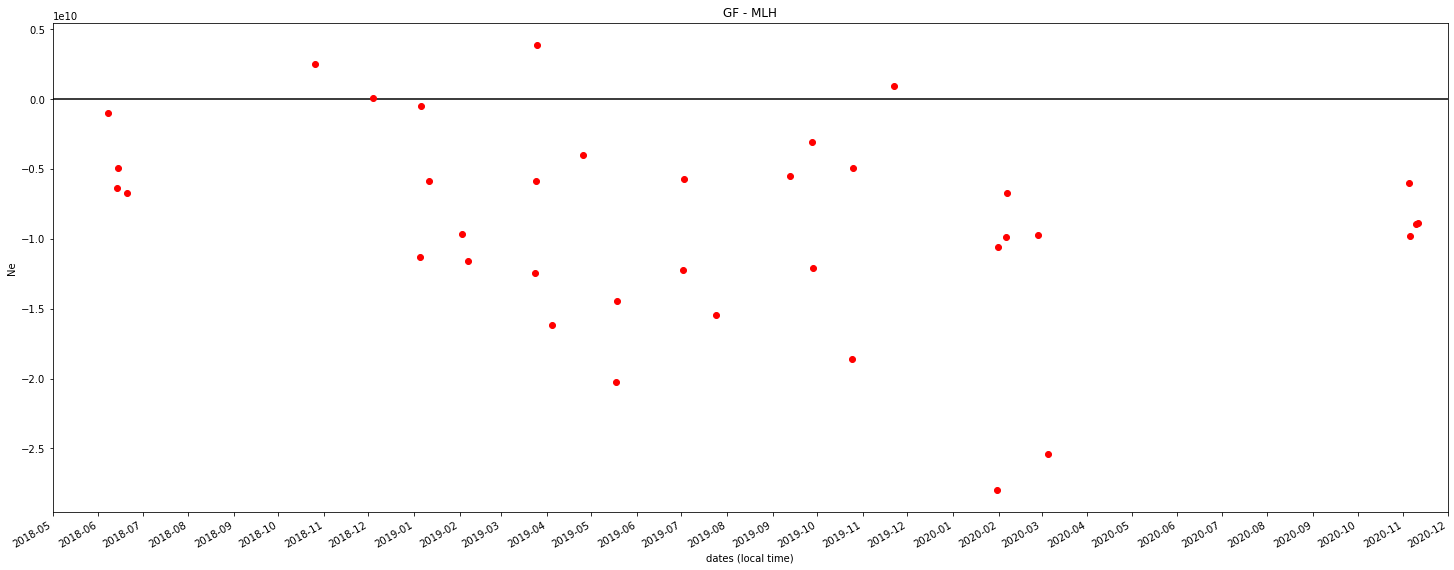

In [17]:
# Convert to matplotlib's internal date format.
x = conjunctions.local_time

fig, ax = plt.subplots(figsize=(25,10))

ax.axhline(y=0, color='k', linestyle='-')


ax.plot(x, conjunctions['diff'], 'ro')

ax.xaxis_date()

months =mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.set_xlim(pd.Timestamp("2018-05"),pd.Timestamp("2020-12"))

# plt.ylim(-3,3)


# Optional. Just rotates x-ticklabels in this case.
fig.autofmt_xdate()

plt.title('GF - MLH')

plt.xlabel('dates (local time)')
plt.ylabel('Ne')


months =mdates.MonthLocator(interval=1)
ax.xaxis.set_major_locator(months)


In [18]:
date=[]
time=[]

for i in iter(range(0,len(conjunctions))):

    
    date.append(str(conjunctions.local_time[i])[:10])
    time.append(str(conjunctions.local_time[i])[11:])

Text(0, 0.5, 'Ne')

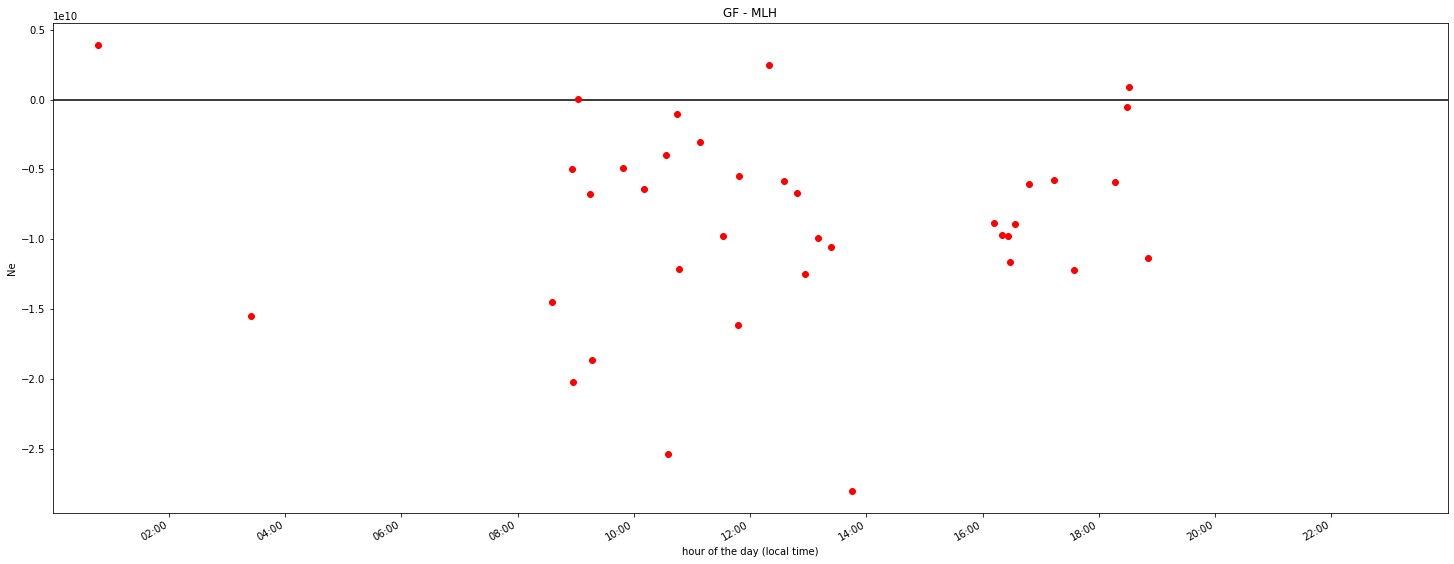

In [19]:
# Convert to matplotlib's internal date format.
x = mdates.datestr2num(time)

fig, ax = plt.subplots(figsize=(25,10))

ax.axhline(y=0, color='k', linestyle='-')


ax.plot(x, conjunctions['diff'], 'ro')

ax.xaxis_date()

# plt.ylim(-3,3)


hours =mdates.HourLocator(interval=2)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_xlim(pd.Timestamp("00:00:01"),pd.Timestamp("23:59:59"))

# Optional. Just rotates x-ticklabels in this case.
fig.autofmt_xdate()

plt.title('GF - MLH')
plt.xlabel('hour of the day (local time)')
plt.ylabel('Ne')

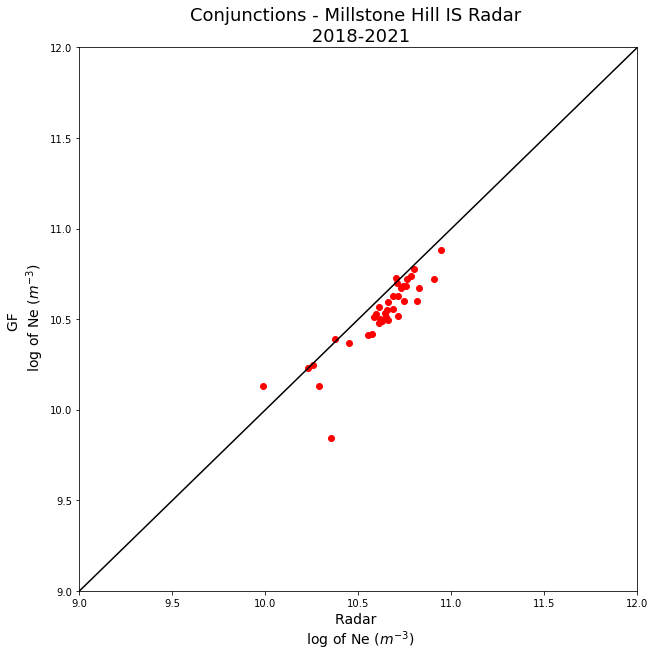

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
fig.set_facecolor('white')



plt.plot([8,12],[8,12], color='k')

versions = np.unique(conjunctions.version)

for i in iter(range(0,len(versions))):

    plt.scatter(conjunctions[conjunctions.version == versions[i]].nel_mlh,conjunctions[conjunctions.version == versions[i]].nel_grf, color = 'r')


plt.xlim(9,12)
plt.ylim(9,12)

plt.xlabel('Radar \n log of Ne $(m^{-3})$',fontsize=14)
plt.ylabel('GF \n log of Ne $(m^{-3})$',fontsize=14)

plt.title("Conjunctions - Millstone Hill IS Radar \n 2018-2021", fontsize=18)

plt.savefig('conjunctions_report.png')


In [16]:
10e-3


0.01